In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
# Add parent directory to path
sys.path.append(os.path.abspath('..'))

import numpy as np
import igraph as ig
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

import regularizers as reg
from GmGM import GmGM
from utilities import *
from nonparanormal_skeptic import *

from other_algs.EiGLasso import EiGLasso, EiGLasso_cov

# Change colorscheme to be colorblind friendly
from cycler import cycler
linestyle_cycler = cycler('linestyle',['-','--',':','-.'])
color_cycler = cycler('color',['k','orange','m','darkgreen'])
plt.rc('axes', prop_cycle=linestyle_cycler + color_cycler)

import timeit

In [3]:
# These are the results from ZiLN
ziln_df = pd.read_csv("../data/ll-deep-assortativities.csv", index_col=0)

# Helper Functions

In [4]:
def calculate_assortativity(
    thresholds: np.ndarray,
    preds: dict[str, np.ndarray]
) -> np.ndarray:
    results = np.zeros((len(thresholds), 3, 5))
    threshold_types = ["All", "Per Row", "Per Col"]
    for idx, threshold in enumerate(thresholds):
        if idx % (len(thresholds) // 10) == 0:
            print(f"Threshold {idx} of {len(thresholds)}")
        # Overall #######################

        # Threshold
        preds_all = shrink_sparsities(
            preds,
            {"People": threshold / 565**2, "Species": threshold / 565**2}
        )

        # Create igraph graph from preds["Cell"]
        g = ig.Graph.Adjacency(
            (preds_all["Species"] + preds_all["Species"].T) != 0,
            mode="undirected",
            #attr="weight",
            loops=False
        )

        # Calculate assortativity
        results[idx, 0, 0] = g.assortativity(taxmat["Phylum"].cat.codes-1)
        results[idx, 0, 1] = g.assortativity(taxmat["Class"].cat.codes-1)
        results[idx, 0, 2] = g.assortativity(taxmat["Order"].cat.codes-1)
        results[idx, 0, 3] = g.assortativity(taxmat["Family"].cat.codes-1)
        results[idx, 0, 4] = g.assortativity(taxmat["Genus"].cat.codes-1)

        # Per Row #######################

        # Threshold
        preds_row = shrink_per_row(
            preds,
            {"People": int(threshold / 565), "Species": int(threshold / 565)}
        )

        # Create igraph graph from preds["Cell"]
        g = ig.Graph.Adjacency(
            (preds_row["Species"] + preds_row["Species"].T) != 0,
            mode="undirected",
            #attr="weight",
            loops=False
        )

        # Calculate assortativity
        results[idx, 1, 0] = g.assortativity(taxmat["Phylum"].cat.codes)
        results[idx, 1, 1] = g.assortativity(taxmat["Class"].cat.codes)
        results[idx, 1, 2] = g.assortativity(taxmat["Order"].cat.codes)
        results[idx, 1, 3] = g.assortativity(taxmat["Family"].cat.codes)
        results[idx, 1, 4] = g.assortativity(taxmat["Genus"].cat.codes)

        # Per Col #######################

        # Threshold
        preds_col = shrink_per_col(
            preds,
            {"People": int(threshold / 565), "Species": int(threshold / 565)}
        )

        # Create igraph graph from preds["Cell"]
        g = ig.Graph.Adjacency(
            (preds_col["Species"] + preds_col["Species"].T) != 0,
            mode="undirected",
            #attr="weight",
            loops=False
        )

        # Calculate assortativity
        results[idx, 2, 0] = g.assortativity(taxmat["Phylum"].cat.codes)
        results[idx, 2, 1] = g.assortativity(taxmat["Class"].cat.codes)
        results[idx, 2, 2] = g.assortativity(taxmat["Order"].cat.codes)
        results[idx, 2, 3] = g.assortativity(taxmat["Family"].cat.codes)
        results[idx, 2, 4] = g.assortativity(taxmat["Genus"].cat.codes)
    return results

# Load Multimodal Data
This data is from the LifeLines-DEEP dataset, which is not publically available (access can be requested, you will have to reach out to them).

If you cannot get ahold of it, but still want to repeat our results, scroll down further in the notebook!

In [5]:
import muon as mu
import scanpy as sc
from anndata import AnnData
import sklearn.cluster as clust

/Users/baileyandrew/mambaforge/envs/GmGM-Polyglot-intel/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/baileyandrew/mambaforge/envs/GmGM-Polyglot-intel/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/baileyandrew/mambafor

In [6]:
# Get the taxa
taxmat = pd.read_csv("../data/ll-deep-taxmat.csv", index_col=0)
taxmat.columns = ["Domain", "Phylum", "Class", "Order", "Family", "Genus"]
taxmat = taxmat.fillna("Unknown")
taxmat = taxmat.apply(lambda x: x.astype("category"))

In [7]:
# Read in the mapping linking person ids from metabolomics and metagenomics
# (we actually constructed the latter two datasets such that the nth row matches
# up in all of them - but this still contains gender info)
map_df = pd.read_csv(
    "../data/LL-Deep Data - Processed/Map.csv",
    index_col=0
)
print(map_df.shape)

# Read in the metabolomics data
metabolomics_df = pd.read_csv(
    "../data/LL-Deep Data - Processed/Metabolomics.csv",
    index_col=0
)
print(metabolomics_df.shape)

# Read in the metagenomics data
metagenomics_df = pd.read_csv(
    "../data/LL-Deep Data - Processed/MetagenomicsShotgun.csv",
    index_col=0
)
old_shape = metagenomics_df.shape

# Only keep the species who appear in more than 20% of the people
#keep_idxs = ((counts > 0).sum(axis=0) > 0.2 * counts.shape[0]).values
#counts = counts.loc[:, keep_idxs]
#taxmat = taxmat.loc[keep_idxs, :]
keep_idxs = (metagenomics_df > 0).sum(axis=0) > 0.2 * metagenomics_df.shape[0]
metagenomics_df = metagenomics_df.loc[:, keep_idxs]
taxmat = taxmat.loc[keep_idxs.values, :]

print(old_shape, '->', metagenomics_df.shape)

(1054, 3)
(1054, 1183)
(1054, 3957) -> (1054, 564)


In [8]:
# Load our data into a MuData object
metabol_ann = AnnData(
    X = metabolomics_df.to_numpy()
)
metabol_ann.obs_names = metabolomics_df.index
metabol_ann.var_names = metabolomics_df.columns

metagen_ann = AnnData(
    X = metagenomics_df.to_numpy()
)
metagen_ann.obs_names = metabolomics_df.index # note this is the same as metabolomics
metagen_ann.var_names = metagenomics_df.columns

mudata = mu.MuData({
    "metabolomics": metabol_ann,
    "metagenomics_shotgun": metagen_ann
})

mudata.obs["Gender"] = map_df["Gender"].to_numpy()

# Log transform the data (this modifies in place)
sc.pp.log1p(mudata["metabolomics"])
sc.pp.log1p(mudata["metagenomics_shotgun"])

In [9]:
# Note - for some reason, with scanpy, we only keep 564 species,
# but with manual filtering (see bottom of this notebook), we keep 565
mudata

MuData object with n_obs × n_vars = 1054 × 1747
  obs:	'Gender'
  2 modalities
    metabolomics:	1054 x 1183
      uns:	'log1p'
    metagenomics_shotgun:	1054 x 564
      uns:	'log1p'

In [10]:
shotgun_array = mudata["metagenomics_shotgun"].X
metabol_array = mudata["metabolomics"].X

## Experiment 3: UMAP Consistency

In [11]:
GmGM_results = GmGM(
    {
        "metagenomics_shotgun": shotgun_array - shotgun_array.mean(),
        "metabolomics": metabol_array - metabol_array.mean()
    },
    {
        "metagenomics_shotgun": ("People", "Species"),
        "metabolomics": ("People", "Metabolite")
    },
    tol=1e-8,
    max_iter=1000,
    verbose=False,
    _always_regularize=True,
    _check_overstep_each_iter=False,
    force_posdef=False
)

In [12]:
shrunk = shrink_sparsities(GmGM_results, {"People": 0, "Species": 0.07, "Metabolite": 0})["Species"]
shrunk = (shrunk + shrunk.T) / 2
shrunk_graph = ig.Graph.Adjacency(shrunk != 0).as_undirected()

In [13]:
# Create a transposed dataset to make the UMAP easy to plot
transposed_anndata = AnnData(shotgun_array.T)
transposed_anndata.obs_names = mudata["metagenomics_shotgun"].var_names
transposed_anndata.var_names = mudata["metagenomics_shotgun"].obs_names
sc.pp.log1p(transposed_anndata)

In [14]:
# taken from https://github.com/ftheberge/Ensemble-Clustering-for-Graphs
def community_ecg(self, weights=None, ens_size = 16, min_weight = 0.05):
    W = [0]*self.ecount()
    ## Ensemble of level-1 Louvain
    for i in range(ens_size):
        p = np.random.permutation(self.vcount()).tolist()
        g = self.permute_vertices(p)
        l1 = g.community_multilevel(weights=weights, return_levels=True)[0].membership
        b = [l1[p[x.tuple[0]]]==l1[p[x.tuple[1]]] for x in self.es]
        W = [W[i]+b[i] for i in range(len(W))]
    W = [min_weight + (1-min_weight)*W[i]/ens_size for i in range(len(W))]
    ## Force min_weight outside 2-core
    core = self.shell_index()
    ecore = [min(core[x.tuple[0]],core[x.tuple[1]]) for x in self.es]
    w = [W[i] if ecore[i]>1 else min_weight for i in range(len(ecore))]
    part = self.community_multilevel(weights=w)
    part._modularity_params['weights'] = weights
    part.recalculate_modularity()
    part.W = w
    part.CSI = 1-2*np.sum([min(1-i,i) for i in w])/len(w)
    return part

ig.Graph.community_ecg = community_ecg

In [67]:
# Louvain clustering
louvain = shrunk_graph.community_multilevel().membership
transposed_anndata.obs["louvain"] = [f"Cluster {l}" for l in louvain]

# Leiden clustering
leiden = shrunk_graph.community_leiden(resolution=0.0002).membership
transposed_anndata.obs["leiden"] = [f"Cluster {l}" for l in leiden]

# ECG clustering
ecg = shrunk_graph.community_ecg().membership
transposed_anndata.obs["ecg"] = [f"Cluster {l}" for l in ecg]

In [56]:
(transposed_anndata.obs["leiden"].value_counts() > 1).sum() / (transposed_anndata.obs["leiden"].value_counts() > 0).sum()

0.494949494949495

In [68]:
transposed_anndata.obs["leiden"].value_counts()

leiden
Cluster 0     551
Cluster 8       2
Cluster 1       1
Cluster 2       1
Cluster 3       1
Cluster 4       1
Cluster 5       1
Cluster 6       1
Cluster 7       1
Cluster 9       1
Cluster 10      1
Cluster 11      1
Cluster 12      1
Name: count, dtype: int64

In [16]:
sc.pp.pca(transposed_anndata, n_comps=30)
sc.pp.neighbors(transposed_anndata)
sc.tl.umap(transposed_anndata)

/Users/baileyandrew/mambaforge/envs/GmGM-Polyglot-intel/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


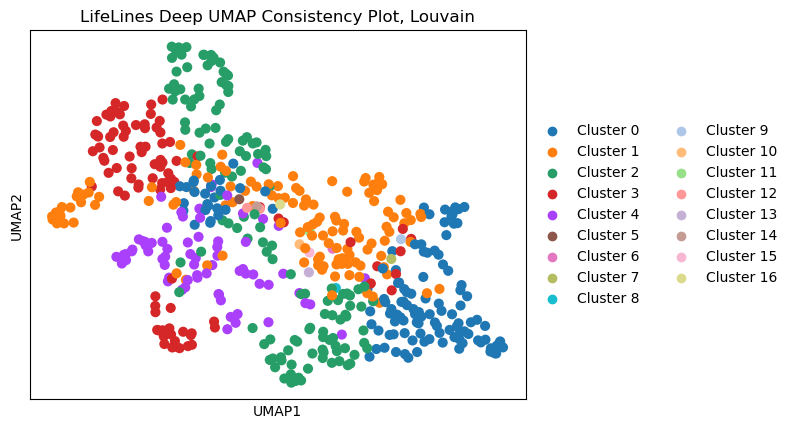

In [17]:
fig, ax = plt.subplots(ncols=1)
sc.pl.umap(
    transposed_anndata,
    color="louvain",
    ax=ax,
    title="LifeLines Deep UMAP Consistency Plot, Louvain"
)
fig.savefig("../out_figs/lifelines-deep-umap-consistency-louvain.png", bbox_inches="tight")
fig.savefig("../out_figs/lifelines-deep-umap-consistency-louvain.svg", bbox_inches="tight")
fig.savefig("../out_figs/lifelines-deep-umap-consistency-louvain.pdf", bbox_inches="tight")

/Users/baileyandrew/mambaforge/envs/GmGM-Polyglot-intel/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


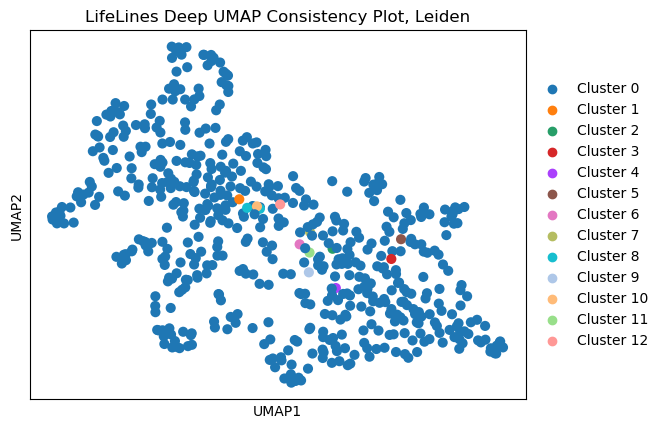

In [70]:
fig, ax = plt.subplots(ncols=1)
sc.pl.umap(
    transposed_anndata,
    color="leiden",
    ax=ax,
    title="LifeLines Deep UMAP Consistency Plot, Leiden"
)
fig.savefig("../out_figs/lifelines-deep-umap-consistency-leiden.png", bbox_inches="tight")
fig.savefig("../out_figs/lifelines-deep-umap-consistency-leiden.svg", bbox_inches="tight")
fig.savefig("../out_figs/lifelines-deep-umap-consistency-leiden.pdf", bbox_inches="tight")

/Users/baileyandrew/mambaforge/envs/GmGM-Polyglot-intel/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


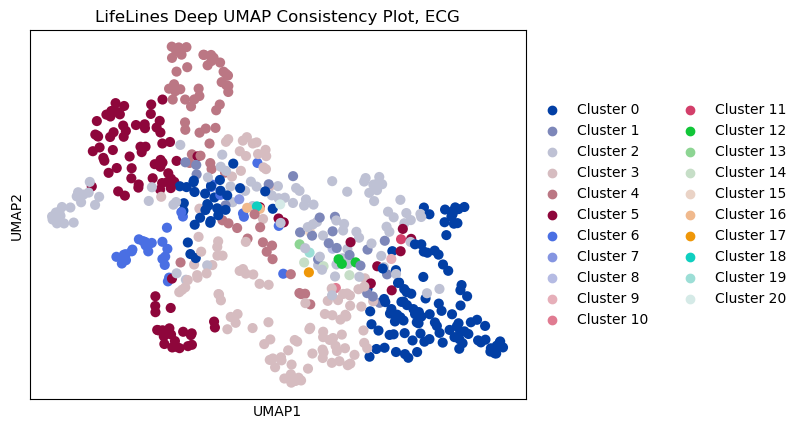

In [37]:
fig, ax = plt.subplots(ncols=1)
sc.pl.umap(
    transposed_anndata,
    color="ecg",
    ax=ax,
    title="LifeLines Deep UMAP Consistency Plot, ECG"
)
fig.savefig("../out_figs/lifelines-deep-umap-consistency-ecg.png", bbox_inches="tight")
fig.savefig("../out_figs/lifelines-deep-umap-consistency-ecg.svg", bbox_inches="tight")
fig.savefig("../out_figs/lifelines-deep-umap-consistency-ecg.pdf", bbox_inches="tight")

In [71]:
sc.tl.tsne(transposed_anndata)

/Users/baileyandrew/mambaforge/envs/GmGM-Polyglot-intel/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


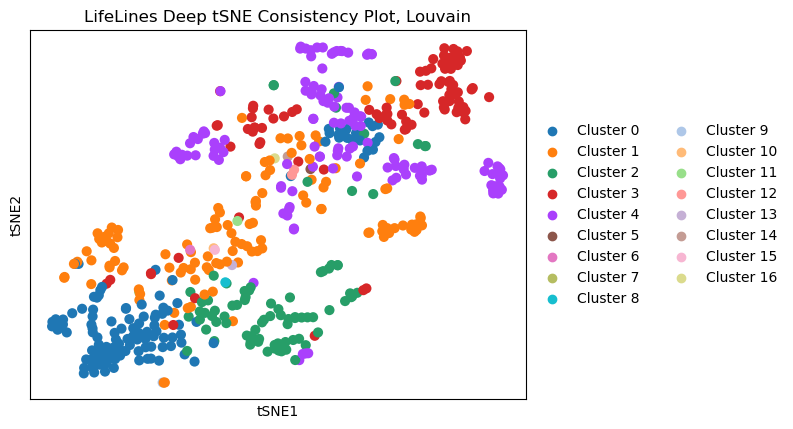

In [72]:
fig, ax = plt.subplots(ncols=1)
sc.pl.tsne(
    transposed_anndata,
    color="louvain",
    ax=ax,
    title="LifeLines Deep tSNE Consistency Plot, Louvain"
)
fig.savefig("../out_figs/lifelines-deep-tsne-consistency-louvain.png", bbox_inches="tight")
fig.savefig("../out_figs/lifelines-deep-tsne-consistency-louvain.svg", bbox_inches="tight")
fig.savefig("../out_figs/lifelines-deep-tsne-consistency-louvain.pdf", bbox_inches="tight")

/Users/baileyandrew/mambaforge/envs/GmGM-Polyglot-intel/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


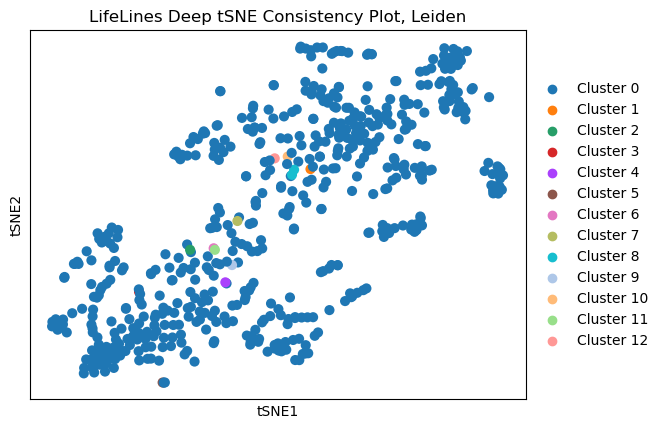

In [73]:
fig, ax = plt.subplots(ncols=1)
sc.pl.tsne(
    transposed_anndata,
    color="leiden",
    ax=ax,
    title="LifeLines Deep tSNE Consistency Plot, Leiden"
)
fig.savefig("../out_figs/lifelines-deep-tsne-consistency-leiden.png", bbox_inches="tight")
fig.savefig("../out_figs/lifelines-deep-tsne-consistency-leiden.svg", bbox_inches="tight")
fig.savefig("../out_figs/lifelines-deep-tsne-consistency-leiden.pdf", bbox_inches="tight")

/Users/baileyandrew/mambaforge/envs/GmGM-Polyglot-intel/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


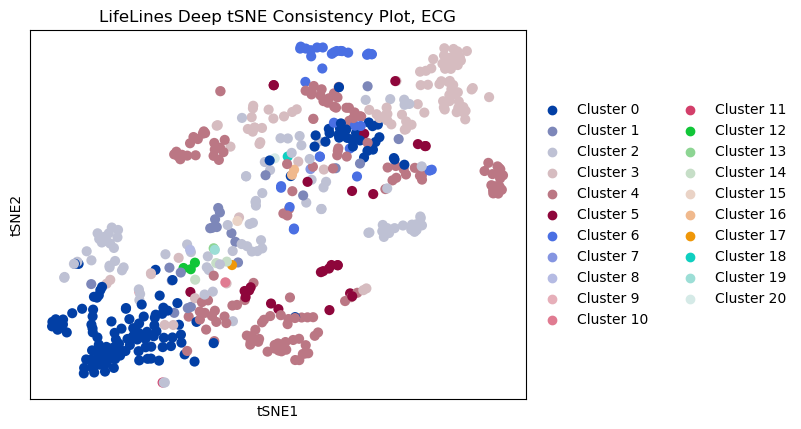

In [74]:
fig, ax = plt.subplots(ncols=1)
sc.pl.tsne(
    transposed_anndata,
    color="ecg",
    ax=ax,
    title="LifeLines Deep tSNE Consistency Plot, ECG"
)
fig.savefig("../out_figs/lifelines-deep-tsne-consistency-ecg.png", bbox_inches="tight")
fig.savefig("../out_figs/lifelines-deep-tsne-consistency-ecg.svg", bbox_inches="tight")
fig.savefig("../out_figs/lifelines-deep-tsne-consistency-ecg.pdf", bbox_inches="tight")